In [1]:
%load_ext autoreload
%autoreload 2
%cd C:\MAD4AG
%matplotlib inline

C:\MAD4AG


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import warnings

warnings.filterwarnings('ignore')

In [3]:
file_name = f'./dbs/intermediate/stops_2.parquet'

#Read each batchs file
df = pd.read_parquet(file_name)

In [4]:
print('The number of stops: ',len(df))
df = df[df.holiday_s != 1]
df = df[df.weekday_s == 1]
df = df.drop(['holiday_s', 'weekday_s'], axis=1)

print('The number of stops in weekday and non-holiday: ', len(df))

The number of stops:  29006512
The number of stops in weekday and non-holiday:  13453097


## drop stop points that are detected in the home cluster.

In [5]:
df_h = pd.read_parquet(f'./dbs/intermediate/home_inference.parquet')
df_h.drop_duplicates(subset='uid', keep='first', inplace=True)

In [6]:
aaa = df.head(1000)

In [7]:
df_1 = df.loc[:,['uid', 'localtime', 'loc', 'h_s', 'dur', 'seq', 'cluster', 'Deso', 'ANDAMAL_1', 'distance']]


df_1 = pd.merge(df_1, df_h[['uid','cluster','score']], on= ['uid','cluster'], how="left")
df_1 = df_1[df_1.score.isnull()]
df_1.drop(columns=['score'], inplace=True)

### repeat each row (stop) based on stay duration.
### e.g., if stay in a stop longer than 30 min, make two stops

In [8]:
df_stop = df_1.copy()

In [9]:
df_stop['dur_rp'] = (df_stop['dur'] / 30) + 1
df_stop['dur_rp'] = df_stop['dur_rp'].astype(int)
df_stop = pd.DataFrame(np.repeat(df_stop.values, df_stop['dur_rp'].tolist(), axis=0), columns=df_stop.columns)

df_stop.drop(['dur_rp'], inplace=True, axis=1)

### grouping and auto increment in index based stay


In [10]:
df_stop['stay_seq'] = df_stop.groupby(['uid', 'seq']).cumcount()
df_stop['timestamp'] = pd.to_datetime(df_stop['localtime']) + (pd.Timedelta(minutes=30) * df_stop['stay_seq'])
df_stop['hour'] = df_stop['timestamp'].dt.hour

In [11]:
aaa = df_stop.head(1000)

In [12]:
nighthours = (0, 1, 2, 3, 4, 5, 6, 7, 19, 20, 21, 22, 23, 24)

### number of visit for each cluster during night hours
df_day_visit = df_stop[['uid', 'cluster', 'localtime', 'hour']][~df_stop.hour.isin(nighthours)]

In [13]:

df_day_visit['day_visits'] = df_day_visit['localtime'].dt.strftime('%m-%d')

In [14]:

df_day_visit = df_day_visit.groupby(['uid', 'cluster'])['day_visits'].nunique().reset_index()

In [15]:
df_stop = pd.merge(df_stop, df_day_visit, on=['uid', 'cluster'], how='left')

In [16]:
df_stop.columns

Index(['uid', 'localtime', 'loc', 'h_s', 'dur', 'seq', 'cluster', 'Deso',
       'ANDAMAL_1', 'distance', 'stay_seq', 'timestamp', 'hour', 'day_visits'],
      dtype='object')

### remove clusters having less than 2 day stay and 10 score


In [73]:
min_day_visit=3
min_score=30

df_w = df_stop[(~df_stop.hour.isin(nighthours))&(df_stop.day_visits>=min_day_visit)]

df_w = df_w.groupby(['uid','cluster'])['dur'].agg(['sum','count']).reset_index()

df_w.rename({'count':'stops', 'sum':'total_duration' }, axis=1,inplace=True)

## score

In [74]:
def score_calculator(data):
    # represent points consistently as (lat, lon)
    #urban_density, hour = data[['urban_density','hour']].loc[0]
    batch = data[['urban_density','hour']].values[0]

    #print(coords[0])

    home_frequency = pd.read_csv('dbs/intermediate/act_temporal_pattern.csv', index_col='activity')
    home_frequency = home_frequency.loc['Work/School', :].values.tolist()

    data['score'] = home_frequency[batch[1]]

    return data

In [75]:
df_score= df_stop.copy()

df_score= df_score[['uid', 'cluster', 'hour', 'Deso']]

df_score['urban_density'] =df_score['Deso'].str[4]


In [76]:
tqdm.pandas()
df_score = df_score.groupby(['urban_density','hour']).progress_apply(score_calculator)

  0%|          | 0/72 [00:00<?, ?it/s]

In [77]:
df_score = df_score[~df_score.hour.isin(nighthours)]
df_score = df_score.groupby(['uid','cluster'])['score'].sum().reset_index()


df_w = pd.merge(df_w, df_score[['uid','cluster','score']], on=['uid','cluster'], how='left')

### sort the clusters by score and keep the four highest score clusters as potential work positions

In [78]:
df_w= df_w.sort_values(['uid','score'], ascending=False)


df_w = df_w.groupby('uid').head(4)


In [79]:
# add building types to each cluster by proximity


df_w = pd.merge(df_w, df[['uid','cluster','ANDAMAL_1', 'distance' ]].drop_duplicates(), on=['uid','cluster'], how='left')
#df_h['ANDAMAL_1'].value_counts(normalize=True)
building_metadata = pd.read_csv(f'./dbs/building_purpose_codes.csv', encoding='ISO-8859-1', sep=';')

df_w = pd.merge(df_w, building_metadata[['Code', 'Purpose of building']], left_on='ANDAMAL_1', right_on='Code', how='left')

df_w.drop(columns=['Code'], inplace=True)

In [80]:
#If the distance to the nearest building is more than 200m, assign 0 to the building type.


df_w.ANDAMAL_1 = np.where(df_w['distance'] >= 0.1 , 0, df_w.ANDAMAL_1)

df_w['Purpose of building'][df_w['ANDAMAL_1'] == 0] = 'no_building'

## generate work potential column
 - if the building type is industrial or agricultural, assign 1
 - if the building type is in certain public facilities like school, hospital or police station, assign 1
 - the score is higher than 20, assign 1

In [81]:
df_w['work_potential']=0

df_w['work_potential'][(df_w['Purpose of building'] =='Industrial')  |(df_w['Purpose of building'] =='Agricultural')]=1

df_w['work_potential'][(df_w.ANDAMAL_1.isin([301,302,304,305,306,307,308,310,310,311,312,313,314,315,317,318,319,321,322,324]))]=1

df_w['work_potential'][df_w.score>min_score]=1

In [82]:
df_w.to_parquet(f'./dbs/intermediate/work_inference.parquet')

### Score distribution of the inferred work locations with highest score


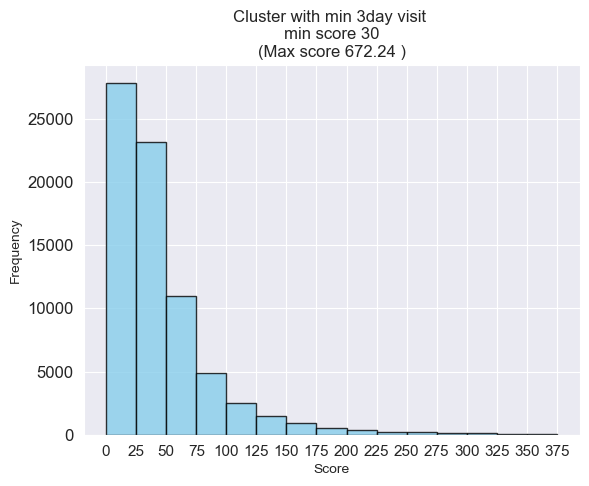

In [83]:
df_w_1 = df_w[df_w['work_potential']==1].groupby('uid').head(1)
plt.hist(df_w_1['score'][df_w_1['score'] <= 400], bins=range(0, 400, 25), color='skyblue', edgecolor='black', alpha=0.8)

# Adding labels and title
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Cluster with min ' + str(min_day_visit) + 'day visit \n' +'min score '+ str(min_score)+ "\n(Max score %.2f )" % (max(df_w_1['score'])))

x_labels = range(0, 400, 25)  # Generate labels from 1 to 24
x_ticks = range(0, 400, 25)  # Position the labels every other data point
#plt.ylim(0, 1.1)
plt.xticks(x_ticks, x_labels, fontsize=11)
plt.yticks(fontsize=12)
plt.savefig('figures/work_score_min_visit_' + str(min_day_visit) +'_min_score '+ str(min_score)+ '.png', dpi=300, bbox_inches="tight")

# Display the plot
plt.show()

In [84]:
work_dist = pd.DataFrame(df_w_1['Purpose of building'].value_counts(normalize=True) * 100).reset_index().rename( columns={'Purpose of building': 'share(%)'})

work_dist['share(%)'] = work_dist['share(%)'].round(2)

work_dist


,index,share(%)
0,Public,36.31
1,Industrial,26.74
2,Residential,20.27
3,Activity,10.77
4,no_building,4.08
5,Other building,1.49
6,Agricultural,0.35


In [85]:
print("Data contains %s devices in weekdays-non holidays."%(len(df.uid.unique())))
print("The number of the potential locations: %s "%(df_w['work_potential'].sum()))

print("The work/school location of %s devices was detected (%s of all devices)."%(len(df_w_1.uid.unique()), (np.round(len(df_w_1.uid.unique())/len(df.uid.unique()), 4)*100)))
print("The work/school location of %s devices could not be detected."%(len(df.uid.unique())-len(df_w_1.uid.unique())))

Data contains 322452 devices in weekdays-non holidays.
The number of the potential locations: 89330 
The work/school location of 73515 devices was detected (22.8 of all devices).
The work/school location of 248937 devices could not be detected.


In [86]:
# df_w_1[['Residential', 'Industrial','Other building', 'Activity', 'Public', 'Agricultural']].sum(axis=0)/len(df_w_1)
